# CNN from Scratch on CIFAR-10

### Import libraries and frameworks

In [1]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import os
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

device = torch.device("cuda")
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

### Preparing Data

In [2]:
os.makedirs(name="dataset",exist_ok=True)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            ),
])

full_train_ds = CIFAR10(root = "dataset/train",
                    train=True,
                    transform=transform,
                    download=True)
test_ds = CIFAR10(root = "dataset/test",
                  train=False,
                  transform=transform,
                  download=True,)

sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train_indices, val_indices = next(sss.split(full_train_ds.data, full_train_ds.targets))

train_ds = torch.utils.data.Subset(full_train_ds, train_indices)
val_ds = torch.utils.data.Subset(full_train_ds,val_indices)

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=128, shuffle=False,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128, shuffle=False,num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Define Model

In [3]:
def conv_block (c_in:int, c_out:int):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size= 3, padding=1, bias=False),
        nn.BatchNorm2d(c_out),
        nn.ReLU(inplace=True),
    )

class MyNet(nn.Module):
    def __init__(self, n_classes = 10, base_channels = 64, dropout = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(3,base_channels),

            conv_block(base_channels,base_channels),
            conv_block(base_channels,base_channels*2),

            nn.MaxPool2d(2),

            conv_block(base_channels*2, base_channels*2),
            conv_block(base_channels*2, base_channels*4),

            nn.MaxPool2d(2),

            conv_block(base_channels*4,base_channels*4),
            conv_block(base_channels*4,base_channels*4),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            nn.Dropout(dropout),
            nn.Linear(base_channels*4, n_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)




In [4]:
summary(model=MyNet(),
        input_size=(1, 3, 32, 32),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
MyNet                                    [1, 3, 32, 32]            [1, 10]                   --                        True
├─Sequential: 1-1                        [1, 3, 32, 32]            [1, 10]                   --                        True
│    └─Sequential: 2-1                   [1, 3, 32, 32]            [1, 64, 32, 32]           --                        True
│    │    └─Conv2d: 3-1                  [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     True
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           [1, 64, 32, 32]           128                       True
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─Sequential: 2-2                   [1, 64, 32, 32]           [1, 64, 32, 32]           --                        True
│    

### Training

In [ ]:
def train(model, loss_func, optimizer, scheduler, train_loader, valid_loader, epochs):
    results = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        train_acc = 0.0
        for X, y in tqdm(train_loader):
            X, y = X.to(device), y.long().to(device)
            y_hat = model(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (y_hat.argmax(dim=1) == y).sum().item()
        
        
        with torch.inference_mode():
            val_loss = 0.0
            val_acc = 0.0
            for  X, y in valid_loader:
                X, y = X.to(device), y.long().to(device)
                y_hat = model(X)
                loss = loss_func(y_hat, y)

                val_loss += loss.item()
                val_acc += (y_hat.argmax(dim=1) == y).sum().item()
        
        
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        train_acc /= len(train_loader.dataset)
        val_acc /= len(valid_loader.dataset)

        if scheduler is not None:
            scheduler.step(val_acc)

        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)

        print(f'[INFO] - Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
        
    return results

In [6]:
model = MyNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr= 1e-2, momentum = 0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer=optimizer,mode='max', factor=0.5, patience=5)

In [7]:
results = train(model, loss_func, optimizer, scheduler, train_loader, val_loader, epochs= 50)

100%|██████████| 313/313 [00:49<00:00,  6.32it/s]


[INFO] - Epoch: 1 | Train Loss: 1.5492 | Val Loss: 1.2599 | Train Acc: 0.4268 | Val Acc: 0.5448


100%|██████████| 313/313 [00:46<00:00,  6.77it/s]


[INFO] - Epoch: 2 | Train Loss: 1.1575 | Val Loss: 1.0410 | Train Acc: 0.5845 | Val Acc: 0.6294


100%|██████████| 313/313 [00:39<00:00,  7.92it/s]


[INFO] - Epoch: 3 | Train Loss: 0.9794 | Val Loss: 0.9291 | Train Acc: 0.6521 | Val Acc: 0.6751


100%|██████████| 313/313 [00:48<00:00,  6.51it/s]


[INFO] - Epoch: 4 | Train Loss: 0.8649 | Val Loss: 0.8547 | Train Acc: 0.6953 | Val Acc: 0.6978


100%|██████████| 313/313 [00:39<00:00,  7.96it/s]


[INFO] - Epoch: 5 | Train Loss: 0.7844 | Val Loss: 0.7714 | Train Acc: 0.7245 | Val Acc: 0.7323


100%|██████████| 313/313 [00:36<00:00,  8.50it/s]


[INFO] - Epoch: 6 | Train Loss: 0.7140 | Val Loss: 0.7133 | Train Acc: 0.7526 | Val Acc: 0.7535


100%|██████████| 313/313 [00:36<00:00,  8.51it/s]


[INFO] - Epoch: 7 | Train Loss: 0.6582 | Val Loss: 0.6735 | Train Acc: 0.7718 | Val Acc: 0.7685


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


[INFO] - Epoch: 8 | Train Loss: 0.6192 | Val Loss: 0.6220 | Train Acc: 0.7859 | Val Acc: 0.7908


100%|██████████| 313/313 [00:38<00:00,  8.04it/s]


[INFO] - Epoch: 9 | Train Loss: 0.5760 | Val Loss: 0.5952 | Train Acc: 0.8012 | Val Acc: 0.7941


100%|██████████| 313/313 [00:38<00:00,  8.24it/s]


[INFO] - Epoch: 10 | Train Loss: 0.5447 | Val Loss: 0.5792 | Train Acc: 0.8132 | Val Acc: 0.8046


100%|██████████| 313/313 [00:37<00:00,  8.32it/s]


[INFO] - Epoch: 11 | Train Loss: 0.5225 | Val Loss: 0.5666 | Train Acc: 0.8192 | Val Acc: 0.8033


100%|██████████| 313/313 [00:37<00:00,  8.30it/s]


[INFO] - Epoch: 12 | Train Loss: 0.4927 | Val Loss: 0.5258 | Train Acc: 0.8312 | Val Acc: 0.8221


100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


[INFO] - Epoch: 13 | Train Loss: 0.4664 | Val Loss: 0.5087 | Train Acc: 0.8413 | Val Acc: 0.8286


100%|██████████| 313/313 [00:38<00:00,  8.20it/s]


[INFO] - Epoch: 14 | Train Loss: 0.4334 | Val Loss: 0.5146 | Train Acc: 0.8526 | Val Acc: 0.8220


100%|██████████| 313/313 [00:38<00:00,  8.17it/s]


[INFO] - Epoch: 15 | Train Loss: 0.4218 | Val Loss: 0.4855 | Train Acc: 0.8556 | Val Acc: 0.8370


100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


[INFO] - Epoch: 16 | Train Loss: 0.4071 | Val Loss: 0.4563 | Train Acc: 0.8620 | Val Acc: 0.8487


100%|██████████| 313/313 [00:39<00:00,  7.92it/s]


[INFO] - Epoch: 17 | Train Loss: 0.3855 | Val Loss: 0.4544 | Train Acc: 0.8691 | Val Acc: 0.8430


100%|██████████| 313/313 [00:38<00:00,  8.14it/s]


[INFO] - Epoch: 18 | Train Loss: 0.3698 | Val Loss: 0.4506 | Train Acc: 0.8736 | Val Acc: 0.8529


100%|██████████| 313/313 [00:37<00:00,  8.43it/s]


[INFO] - Epoch: 19 | Train Loss: 0.3563 | Val Loss: 0.4510 | Train Acc: 0.8813 | Val Acc: 0.8476


100%|██████████| 313/313 [00:37<00:00,  8.42it/s]


[INFO] - Epoch: 20 | Train Loss: 0.3410 | Val Loss: 0.4490 | Train Acc: 0.8848 | Val Acc: 0.8512


100%|██████████| 313/313 [00:38<00:00,  8.17it/s]


[INFO] - Epoch: 21 | Train Loss: 0.3281 | Val Loss: 0.4153 | Train Acc: 0.8899 | Val Acc: 0.8594


100%|██████████| 313/313 [00:45<00:00,  6.84it/s]


[INFO] - Epoch: 22 | Train Loss: 0.3164 | Val Loss: 0.4383 | Train Acc: 0.8918 | Val Acc: 0.8551


100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


[INFO] - Epoch: 23 | Train Loss: 0.3085 | Val Loss: 0.4147 | Train Acc: 0.8963 | Val Acc: 0.8587


100%|██████████| 313/313 [00:37<00:00,  8.30it/s]


[INFO] - Epoch: 24 | Train Loss: 0.2922 | Val Loss: 0.4154 | Train Acc: 0.9019 | Val Acc: 0.8569


100%|██████████| 313/313 [00:45<00:00,  6.95it/s]


[INFO] - Epoch: 25 | Train Loss: 0.2773 | Val Loss: 0.4003 | Train Acc: 0.9066 | Val Acc: 0.8670


100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


[INFO] - Epoch: 26 | Train Loss: 0.2714 | Val Loss: 0.4039 | Train Acc: 0.9091 | Val Acc: 0.8654


100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


[INFO] - Epoch: 27 | Train Loss: 0.2613 | Val Loss: 0.4030 | Train Acc: 0.9130 | Val Acc: 0.8656


100%|██████████| 313/313 [00:41<00:00,  7.46it/s]


[INFO] - Epoch: 28 | Train Loss: 0.2532 | Val Loss: 0.3975 | Train Acc: 0.9149 | Val Acc: 0.8651


100%|██████████| 313/313 [00:40<00:00,  7.75it/s]


[INFO] - Epoch: 29 | Train Loss: 0.2414 | Val Loss: 0.3909 | Train Acc: 0.9186 | Val Acc: 0.8691


100%|██████████| 313/313 [00:37<00:00,  8.38it/s]


[INFO] - Epoch: 30 | Train Loss: 0.2352 | Val Loss: 0.3860 | Train Acc: 0.9209 | Val Acc: 0.8689


100%|██████████| 313/313 [00:43<00:00,  7.17it/s]


[INFO] - Epoch: 31 | Train Loss: 0.2260 | Val Loss: 0.3782 | Train Acc: 0.9247 | Val Acc: 0.8754


100%|██████████| 313/313 [00:43<00:00,  7.23it/s]


[INFO] - Epoch: 32 | Train Loss: 0.2200 | Val Loss: 0.3840 | Train Acc: 0.9273 | Val Acc: 0.8729


100%|██████████| 313/313 [00:47<00:00,  6.61it/s]


[INFO] - Epoch: 33 | Train Loss: 0.2112 | Val Loss: 0.3886 | Train Acc: 0.9289 | Val Acc: 0.8725


100%|██████████| 313/313 [00:51<00:00,  6.06it/s]


[INFO] - Epoch: 34 | Train Loss: 0.2034 | Val Loss: 0.3699 | Train Acc: 0.9331 | Val Acc: 0.8749


100%|██████████| 313/313 [00:47<00:00,  6.59it/s]


[INFO] - Epoch: 35 | Train Loss: 0.1978 | Val Loss: 0.3852 | Train Acc: 0.9341 | Val Acc: 0.8722


100%|██████████| 313/313 [00:48<00:00,  6.48it/s]


[INFO] - Epoch: 36 | Train Loss: 0.1981 | Val Loss: 0.3841 | Train Acc: 0.9333 | Val Acc: 0.8739


100%|██████████| 313/313 [00:44<00:00,  6.96it/s]


[INFO] - Epoch: 37 | Train Loss: 0.1819 | Val Loss: 0.3951 | Train Acc: 0.9406 | Val Acc: 0.8684


100%|██████████| 313/313 [00:45<00:00,  6.94it/s]


[INFO] - Epoch: 38 | Train Loss: 0.1270 | Val Loss: 0.3270 | Train Acc: 0.9623 | Val Acc: 0.8910


100%|██████████| 313/313 [00:48<00:00,  6.43it/s]


[INFO] - Epoch: 39 | Train Loss: 0.1041 | Val Loss: 0.3100 | Train Acc: 0.9700 | Val Acc: 0.8993


100%|██████████| 313/313 [00:46<00:00,  6.75it/s]


[INFO] - Epoch: 40 | Train Loss: 0.0978 | Val Loss: 0.3171 | Train Acc: 0.9731 | Val Acc: 0.8959


100%|██████████| 313/313 [00:46<00:00,  6.73it/s]


[INFO] - Epoch: 41 | Train Loss: 0.0896 | Val Loss: 0.3522 | Train Acc: 0.9763 | Val Acc: 0.8887


100%|██████████| 313/313 [00:45<00:00,  6.81it/s]


[INFO] - Epoch: 42 | Train Loss: 0.0830 | Val Loss: 0.3343 | Train Acc: 0.9777 | Val Acc: 0.8930


100%|██████████| 313/313 [00:46<00:00,  6.74it/s]


[INFO] - Epoch: 43 | Train Loss: 0.0817 | Val Loss: 0.3347 | Train Acc: 0.9780 | Val Acc: 0.8903


100%|██████████| 313/313 [00:40<00:00,  7.66it/s]


[INFO] - Epoch: 44 | Train Loss: 0.0816 | Val Loss: 0.3402 | Train Acc: 0.9777 | Val Acc: 0.8943


100%|██████████| 313/313 [00:42<00:00,  7.28it/s]


[INFO] - Epoch: 45 | Train Loss: 0.0764 | Val Loss: 0.3339 | Train Acc: 0.9793 | Val Acc: 0.8944


100%|██████████| 313/313 [00:43<00:00,  7.26it/s]


[INFO] - Epoch: 46 | Train Loss: 0.0548 | Val Loss: 0.2987 | Train Acc: 0.9879 | Val Acc: 0.9043


100%|██████████| 313/313 [00:40<00:00,  7.77it/s]


[INFO] - Epoch: 47 | Train Loss: 0.0472 | Val Loss: 0.3102 | Train Acc: 0.9904 | Val Acc: 0.9012


100%|██████████| 313/313 [00:40<00:00,  7.81it/s]


[INFO] - Epoch: 48 | Train Loss: 0.0457 | Val Loss: 0.3112 | Train Acc: 0.9909 | Val Acc: 0.9026


100%|██████████| 313/313 [00:42<00:00,  7.41it/s]


[INFO] - Epoch: 49 | Train Loss: 0.0423 | Val Loss: 0.3060 | Train Acc: 0.9921 | Val Acc: 0.9033


100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


[INFO] - Epoch: 50 | Train Loss: 0.0393 | Val Loss: 0.3060 | Train Acc: 0.9935 | Val Acc: 0.9034


### Testing

In [8]:
def test(model, loss_func, test_loader):
    model.eval()
    with torch.inference_mode():
        test_loss = 0.0
        test_acc = 0.0
        for X,y in test_loader:
            X,y = X.to(device), y.long().to(device)
            y_hat = model(X)
            loss = loss_func(y_hat,y)
            test_loss += loss.item()
            test_acc += (y_hat.argmax(dim=1) == y).sum().item()
        
        test_acc /= len(test_loader.dataset)
        test_loss /= len(test_loader)

        print(f"[INFO] - Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        
        return {'test_loss':test_loss,
                'test_acc': test_acc,
                }

In [12]:
test_result = test(model, loss_func, test_loader)

[INFO] - Test Loss: 0.2958 | Test Accuracy: 0.9047


### Visualize Results

In [10]:
def plot_results(results):
    fig, axes = plt.subplots(1, 2, figsize = (12,6))
    axes[0].plot(results['train_loss'], label='Train Loss')
    axes[0].plot(results['val_loss'], label='Val Loss')
    axes[1].plot(results['train_acc'], label='Train Accuracy')
    axes[1].plot(results['val_acc'], label = 'Val Accuracy')

    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")

    for i in range(2):
        axes[i].grid(True)
        axes[i].set_xlabel("Epoch")
        axes[i].legend()

    fig.suptitle("Evaluation throughout epochs", fontsize=16)
    plt.tight_layout()
    plt.show()

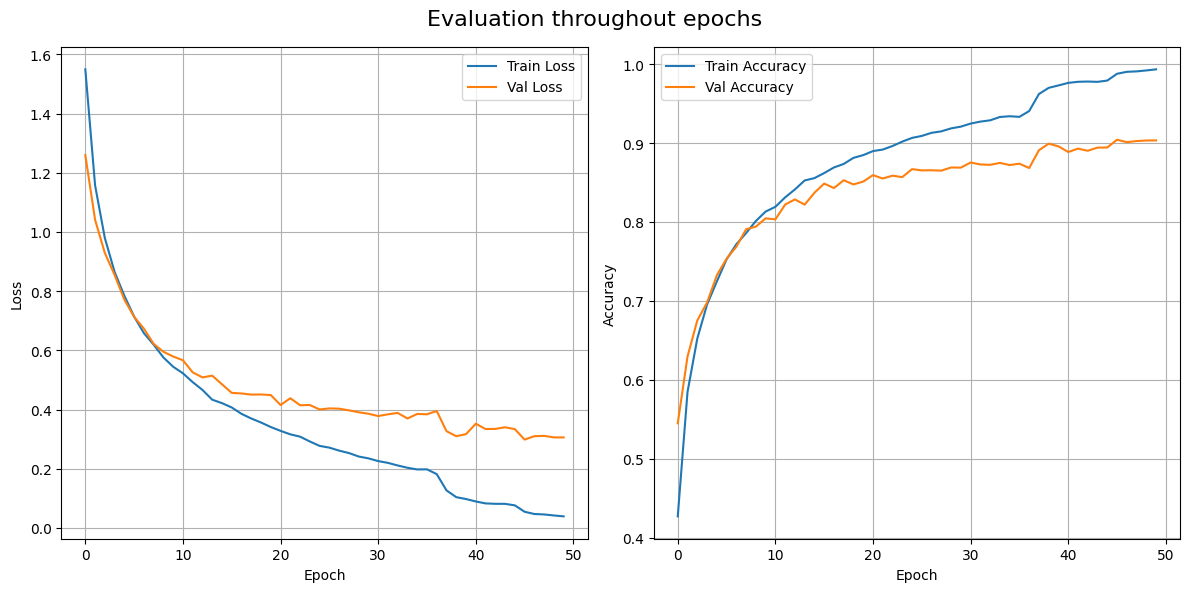

In [11]:
plot_results(results)